# Train DECIPHER model with multi-slices

> (Estimated time: ~5 min with GPU)

In this vignette, we show how to train `DECIPHER` model on multiple spatial slices with batch effects.

1. Check data
2. Run DECIPHER
3. Visualize results

In [1]:
import scanpy as sc

from decipher import DECIPHER
from decipher.utils import scanpy_viz, gex_embedding

In [2]:
!uv pip list | grep decipher
!uv pip list | grep torch

Using Python 3.11.9 environment at: /flash/grp/gglab/xiacr/DECIPHER-dev/conda
cell-decipher                     0.3.1            /flash/grp/gglab/xiacr/DECIPHER-dev
Using Python 3.11.9 environment at: /flash/grp/gglab/xiacr/DECIPHER-dev/conda
harmony-pytorch                   0.1.8
pytorch-lightning                 2.3.3
torch                             2.3.1
torch-cluster                     1.6.3+pt23cu121
torch-geometric                   2.5.3
torch-scatter                     2.1.2+pt23cu121
torch-sparse                      0.6.18+pt23cu121
torch-spline-conv                 1.2.2+pt23cu121
torchaudio                        2.3.1
torchmetrics                      1.5.0
torchvision                       0.18.1


In [3]:
sc.set_figure_params(dpi=80)

## Step 1: Check data

Here we use two simulation slices as an example, you can download them from Google Drive ([slice1](https://drive.google.com/file/d/1-J5YEkhujw1c67VkU1XJYsUonlS2kbZ5/view?usp=sharing), [slice2](https://drive.google.com/file/d/18j8IuiNtvrDj4D7m9fvWAiCDnPmHHfHq/view?usp=sharing))

In [4]:
slice1 = sc.read_h5ad('./slice1.h5ad')
slice2 = sc.read_h5ad('./slice2.h5ad')
adata = slice1.concatenate(slice2, batch_key='slice')

/tmp/ipykernel_2686975/665345369.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = slice1.concatenate(slice2, batch_key='slice')


These two slices share the same cell types:
- T cell
- B cell
- Monocyte

They also share the same spatial patterns:
- region 1: T cell & Monocyte mixed
- region 2: T cell only
- region 3: T cell & B cell mixed

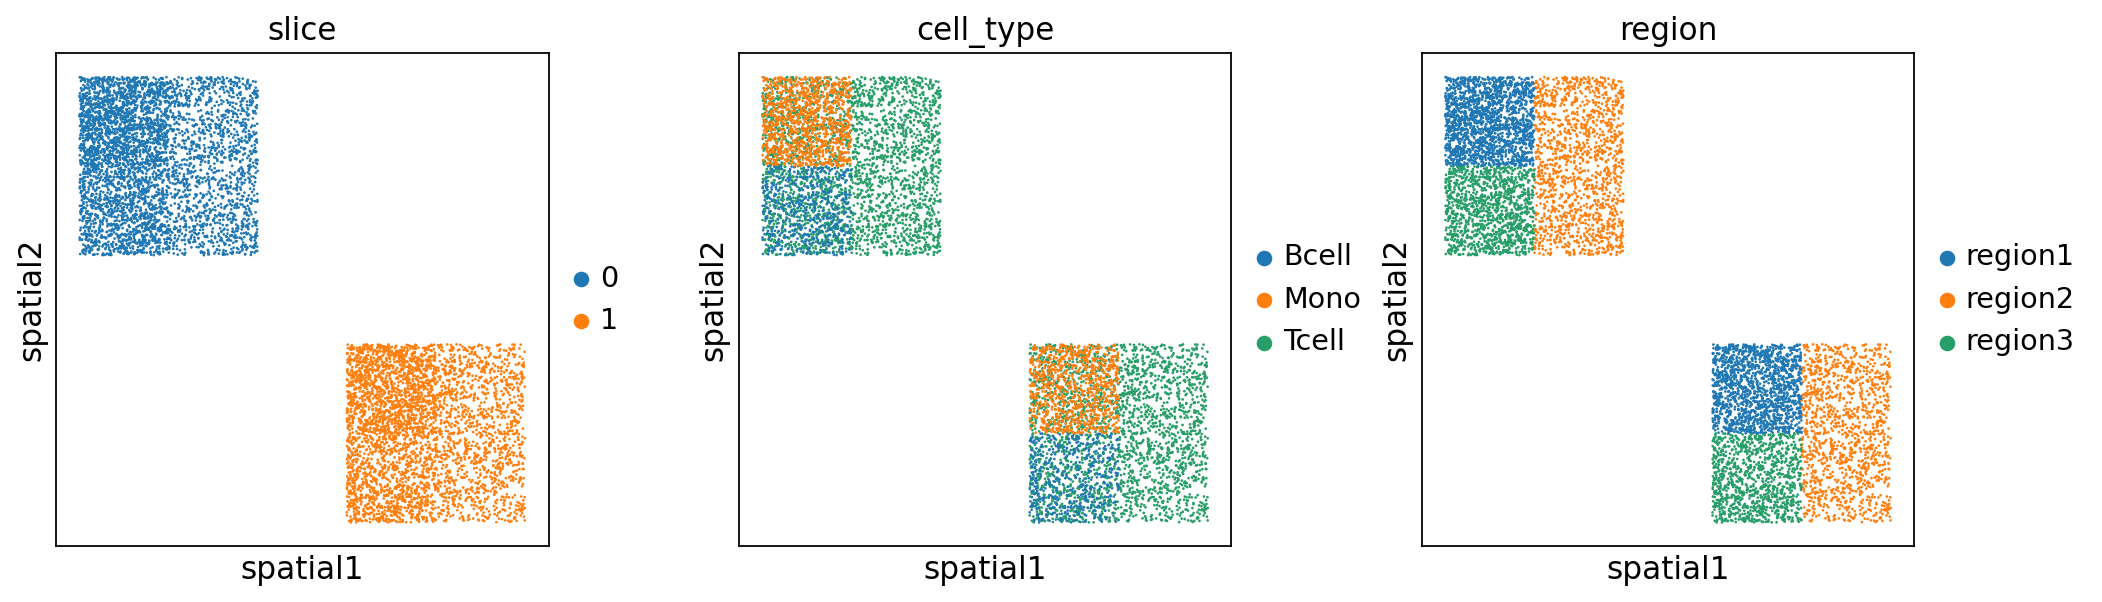

In [5]:
sc.pl.spatial(adata, color=['slice', 'cell_type', 'region'], spot_size=0.03, wspace=0.25)

In [6]:
adata = gex_embedding(adata)

2026-01-20 11:19:37.841 | INFO     | rui_utils.sc:gex_embedding:129 - Gene expression embedding...
2026-01-20 11:19:39.417 | INFO     | rui_utils.gpu:select_free_gpu:39 - Using GPU [0] as computation device.
2026-01-20 11:19:39.419 | INFO     | rui_utils.gpu:manage_gpu:82 - Using GPU 0 and None memory strategy.
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Then we check the batch effects between slices. We can see that the batch effects are significant.

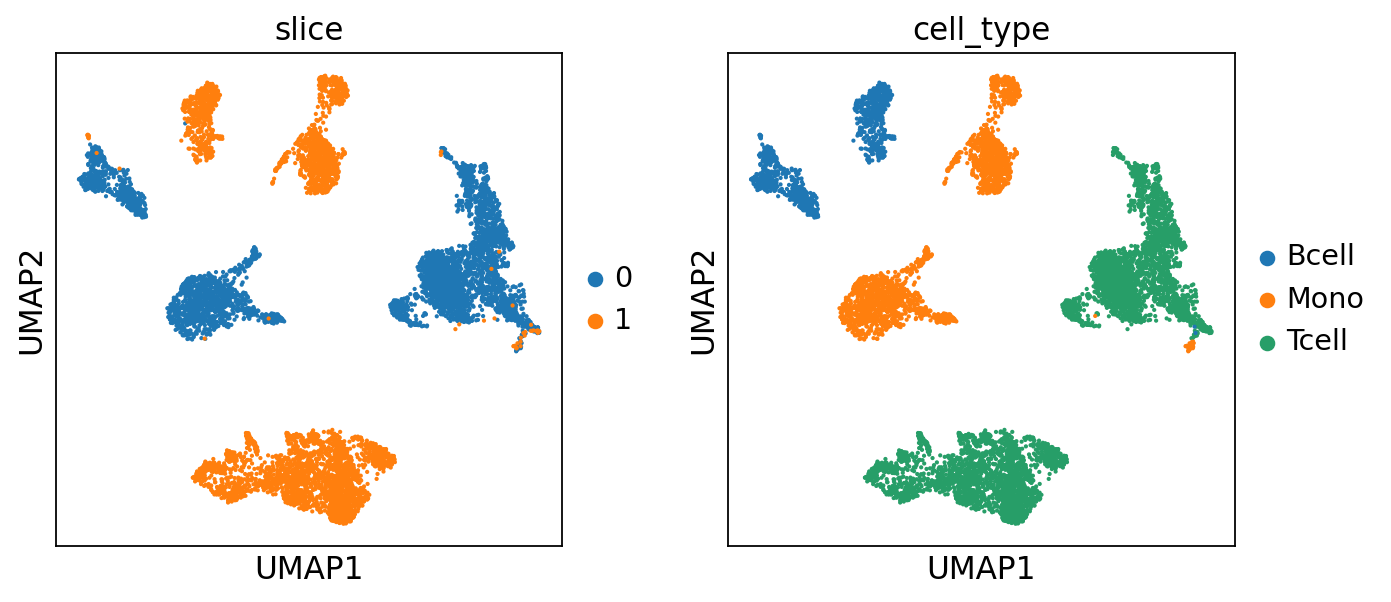

In [7]:
sc.pl.umap(adata, color=['slice', 'cell_type'])

## Step 2: Run DECIPHER

We input a list of Anndata objects, each one is a spaital slices. `DECIPHER` will automatically view each object as one batch and remove the batch effects.

> If you do not want to remove batch effects, just import the CFG by `from decipher import CFG` and  set `CFG.omics.ignore_batch = True`

In [8]:
# Init model
model = DECIPHER(work_dir='./decipher_multi_slices', overwrite=True)

# Reload the slices
slice1 = sc.read_h5ad('./slice1.h5ad')
slice2 = sc.read_h5ad('./slice2.h5ad')

# Register the slices
model.register_data([slice1, slice2])

# Run model
model.fit_omics()

Seed set to 0
/flash/grp/gglab/xiacr/DECIPHER-dev/decipher/data/process.py:42: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_raw[0].concatenate(adata_raw[1:], batch_key="batch", uns_merge="same")
2026-01-20 11:19:47.440 | INFO     | decipher.data.process:omics_data_process:47 - Detected 2 batches.
2026-01-20 11:19:47.442 | INFO     | decipher.data.process:omics_data_process:54 - Preprocessing 8405 cells.
2026-01-20 11:19:47.625 | INFO     | decipher.data.process:omics_data_process:60 - Filter 0 cells with < 3 genes.
2026-01-20 11:19:47.921 | INFO     | decipher.data.process:omics_data_process:63 - Filter 9701 genes with < 3 cells.
2026-01-20 11:19:47.922 | INFO     | decipher.data.process:omics_data_process:70 - Selecting 2000 highly variable genes.
2026-01-20 11:19:48.166 | INFO     | deciph

Training: |          | 0/? [00:00<?, ?it/s]

Metric train/total_loss improved. New best score: 6.298
Epoch 0, global step 33: 'train/total_loss' reached 6.29842 (best 6.29842), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sc_model/epoch=0-step=33.ckpt' as top 3
Metric train/total_loss improved by 1.522 >= min_delta = 0.0. New best score: 4.777
Epoch 1, global step 66: 'train/total_loss' reached 4.77679 (best 4.77679), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sc_model/epoch=1-step=66.ckpt' as top 3
Metric train/total_loss improved by 1.057 >= min_delta = 0.0. New best score: 3.719
Epoch 2, global step 99: 'train/total_loss' reached 3.71932 (best 3.71932), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sc_model/epoch=2-step=99-v1.ckpt' as top 3
Metric train/total_loss improved by 0.262 >= min_delta = 0.0. New best score: 3.457
Epoch 3, global step 132: 'train/total_loss' reached 3.45726 (best 3.45

Training: |          | 0/? [00:00<?, ?it/s]

Metric train/total_loss improved. New best score: 3.651
Epoch 0, global step 33: 'train/total_loss' reached 3.65140 (best 3.65140), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sp_model/epoch=0-step=33.ckpt' as top 3
Epoch 1, global step 66: 'train/total_loss' reached 3.68946 (best 3.65140), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sp_model/epoch=1-step=66.ckpt' as top 3
Metric train/total_loss improved by 0.204 >= min_delta = 0.0. New best score: 3.447
Epoch 2, global step 99: 'train/total_loss' reached 3.44729 (best 3.44729), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sp_model/epoch=2-step=99-v1.ckpt' as top 3
Epoch 3, global step 132: 'train/total_loss' reached 3.48571 (best 3.44729), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher_multi_slices/sp_model/epoch=3-step=132-v1.ckpt' as top 3
Metric train/total_loss impr

Testing: |          | 0/? [00:00<?, ?it/s]

2026-01-20 11:20:14.679 | INFO     | decipher.cls:fit_omics:142 - Results saved to decipher_multi_slices


## Step 3: Visualize results

Finally, we visualize the results. We can see that the batch effects are removed, while cell types and spatial regions are well separated.

In [9]:
adata = slice1.concatenate(slice2, batch_key='slice')
adata.obsm['X_center'] = model.center_emb
adata.obsm['X_nbr'] = model.nbr_emb
adata = scanpy_viz(adata, ['center', 'nbr'])

/tmp/ipykernel_2686975/1478477664.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = slice1.concatenate(slice2, batch_key='slice')
2026-01-20 11:20:14.913 | INFO     | rui_utils.gpu:select_free_gpu:39 - Using GPU [0] as computation device.
2026-01-20 11:20:14.915 | INFO     | rui_utils.gpu:manage_gpu:82 - Using GPU 0 and None memory strategy.
2026-01-20 11:20:14.917 | DEBUG    | rui_utils.sc:_scanpy_viz:263 - Use rapids for visualization.
2026-01-20 11:20:15.303 | INFO     | rui_utils.gpu:manage_gpu:82 - Using GPU 0 and None memory strategy.
2026-01-20 11:20:15.305 | DEBUG    | rui_utils.sc:_scanpy_viz:263 - Use rapids for visualization.


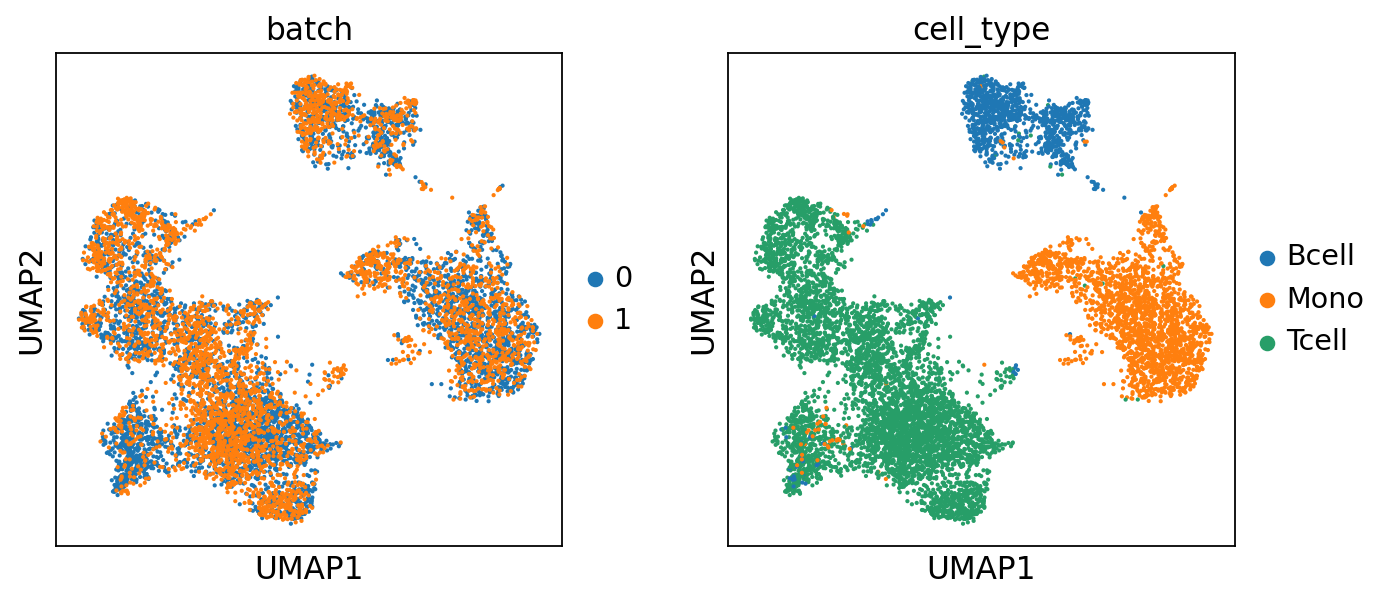

In [10]:
adata.obsm['X_umap'] = adata.obsm['X_umap_center'].copy()
sc.pl.umap(adata, color=['batch', 'cell_type'])

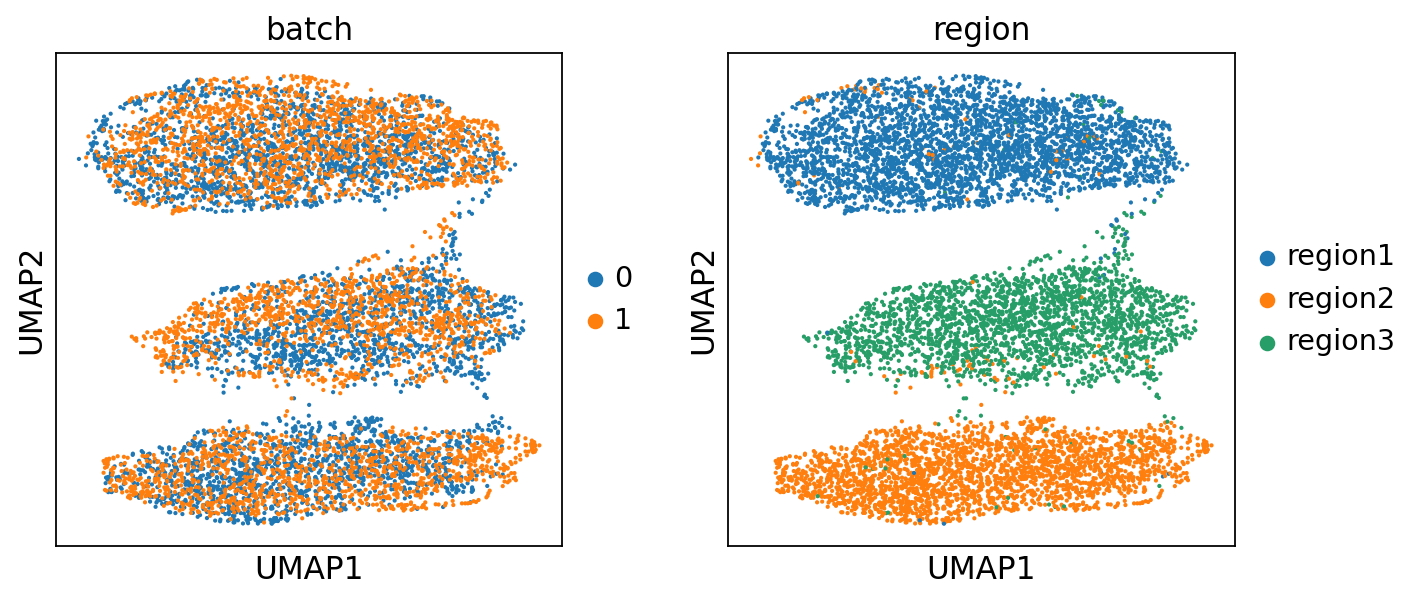

In [11]:
adata.obsm['X_umap'] = adata.obsm['X_umap_nbr'].copy()
sc.pl.umap(adata, color=['batch', 'region'])